In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.decomposition import TruncatedSVD
from sklearn.compose import ColumnTransformer

In [2]:
train_df = pd.read_csv("train.csv")
train_label_df = pd.read_csv("train_label.csv")

In [3]:
print(train_df.info())
print(train_label_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89311 entries, 0 to 89310
Data columns (total 41 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Unnamed: 0                      89311 non-null  int64  
 1   Unnamed: 0.1                    89311 non-null  int64  
 2   Unnamed: 0.1.1                  89311 non-null  int64  
 3   ID                              89311 non-null  int64  
 4   hotel                           89311 non-null  object 
 5   is_canceled                     89311 non-null  int64  
 6   lead_time                       89311 non-null  int64  
 7   arrival_date_year               89311 non-null  int64  
 8   arrival_date_month              89311 non-null  object 
 9   arrival_date_week_number        89311 non-null  int64  
 10  arrival_date_day_of_month       89311 non-null  int64  
 11  stays_in_weekend_nights         89311 non-null  int64  
 12  stays_in_week_nights            

In [4]:
def getRevenue(row):
    if row.is_canceled or row.adr < 0:
        return 0
    return row.adr * (row.stays_in_weekend_nights + row.stays_in_week_nights)

In [5]:
train_df['revenue'] = train_df.apply(getRevenue, axis=1)

In [6]:
monthMap = {'January':'1', 'February':'2', 'March':'3',\
            'April':'4', 'May':'5', 'June':'6',\
            'July':'7', 'August':'8', 'September':'9',\
            'October':'10', 'November':'11', 'December':'12'}
def getArrivalDate(row):
    return pd.to_datetime(str(row.arrival_date_year) + '-' + monthMap[row.arrival_date_month] + '-' + str(row.arrival_date_day_of_month))

In [7]:
train_df['arrival_date'] = train_df.apply(getArrivalDate, axis=1)

In [8]:
dailyRevenue_df = train_df.groupby(['arrival_date']).agg({'revenue': 'sum'})

In [9]:
dailyRevenue_df = dailyRevenue_df.join(train_label_df.set_index('arrival_date'))

In [10]:
dailyRevenue_df = dailyRevenue_df.sort_values(by=['revenue'])

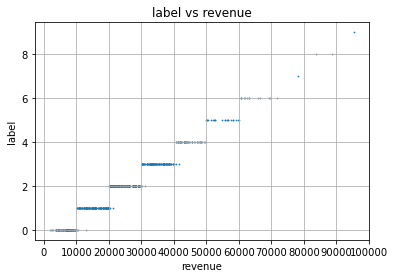

In [11]:
#plt.plot(dailyRevenue_df['revenue'], dailyRevenue_df['label'])
plt.scatter(dailyRevenue_df['revenue'], dailyRevenue_df['label'], s=0.5)
plt.xticks(np.linspace(0,100000,11))
plt.grid(True)
plt.title("label vs revenue")
plt.xlabel("revenue")
plt.ylabel("label")
plt.show()

In [13]:
# PCA analysis

# Transforming the categoric columns
cat_si_step = ('si', SimpleImputer(strategy='constant', fill_value='MISSING'))
cat_ohe_step = ('ohe', OneHotEncoder(sparse=True, handle_unknown='ignore'))
cat_steps = [cat_si_step, cat_ohe_step]
cat_pipe = Pipeline(cat_steps)

# Transforming the numeric columns
num_si_step = ('si', SimpleImputer(strategy='median'))
num_ss_step = ('ss', StandardScaler())
num_steps = [num_si_step, num_ss_step]
num_pipe = Pipeline(num_steps)

adr_numericCols = ['lead_time', 'arrival_date_year', 'stays', 'stays_in_weekend_nights', 'stays_in_week_nights',\
               'adults', 'children', 'babies', 'persons', 'previous_cancellations',\
               'previous_bookings_not_canceled', 'booking_changes', 'days_in_waiting_list',\
               'required_car_parking_spaces', 'total_of_special_requests'
              ]
adr_categoricCols = ['hotel', 'arrival_date_month',\
                'arrival_date_week_number', 'arrival_date_day_of_month', 'meal',\
                'country', 'market_segment', 'distribution_channel',\
                'is_repeated_guest', 'reserved_room_type', 'assigned_room_type',\
                'deposit_type', 'customer_type'
               ]

adr_featureCols = adr_numericCols + adr_categoricCols

In [14]:
adr_train = train_df[adr_featureCols]

In [15]:
adr_ct = ColumnTransformer(transformers=[('cat', cat_pipe, adr_categoricCols), ('num', num_pipe, adr_numericCols)])
adr_train_transformed = adr_ct.fit_transform(adr_train)

In [16]:
adr_svd = TruncatedSVD(n_components=300)

In [17]:
adr_svd.fit(adr_train_transformed)

TruncatedSVD(n_components=300)

In [18]:
print(np.cumsum(adr_svd.explained_variance_ratio_))

[0.00525026 0.13316543 0.22551388 0.30025867 0.35435088 0.40416586
 0.45207441 0.49823521 0.54208088 0.58222282 0.62117499 0.65635446
 0.68897629 0.71356751 0.73401048 0.7516571  0.76771393 0.78164492
 0.7926512  0.80285679 0.8117084  0.81824556 0.82460813 0.83057253
 0.83619367 0.84148388 0.84639086 0.85099185 0.85519759 0.85935527
 0.86334047 0.86721354 0.87083998 0.87437494 0.87769236 0.88089644
 0.88407514 0.88698862 0.88966116 0.89224617 0.89453845 0.89678792
 0.89900671 0.90117709 0.90318214 0.9051541  0.90706508 0.90890914
 0.91066019 0.91236976 0.91403842 0.91570236 0.91732747 0.91894799
 0.92054776 0.92211986 0.92368441 0.92522748 0.92676239 0.9282823
 0.9297887  0.93128179 0.93277401 0.93425407 0.93572459 0.93716832
 0.93860198 0.94003285 0.94145625 0.94286931 0.94428082 0.94565377
 0.94701826 0.94837885 0.94970973 0.9509585  0.95220551 0.95340287
 0.95456878 0.9557085  0.95682185 0.95790091 0.95894459 0.95997611
 0.96100026 0.96201409 0.96300344 0.96397943 0.96494768 0.96590